In [74]:
# For each blockage point which does not have a blockage point within the preceding Tobs samples, generate a set of Tp = pred_length examples featuring blockage
# by applying a sliding window that increases the number of samples between the last observation and the blockage by 1 each time. Only do this as long as it does
# not introduce a blockage into the observation window.
# We then need to find an equal number of non-blockage examples by generating a list of candidates and picking the examples such that they are well spread out
def split_data(samples, labels, blockage_points, Tobs, Tp):
	blockage_array = np.array(blockage_points, dtype=np.int32)
	# Determine the spacing between blockage points
	blockage_spacings = blockage_array[1:] - blockage_array[:-1]
	# Determine the blockage points which mark the start of a blockage
	blockage_start_points = np.array([blockage_points[0]], dtype=np.int32)
	blockage_start_points = np.concatenate([blockage_start_points, (blockage_points[1:])[blockage_spacings > 1]])
	# Generate a list of <observation sequence, label> pairings with blockages
	blk_obs_target_pairs = []
	for bsp in blockage_start_points.tolist():
		# Make sure there is at least a full Tobs observations available, or else we cannot use the blockage
		if Tobs > bsp:
			continue
		for j in range(Tp):
			# Make sure there are enough observation samples available 
			if Tobs + j > bsp:
				continue
			# Make sure the observation samples do not contain blockages
			if np.sum(labels[bsp - (Tobs + j):bsp]) > 0:
				continue
			obs = samples[bsp - (Tobs + j):bsp]
			blk_obs_target_pairs.append([obs, 1])
	# print(len(obs_target_pairs)) # Number of pairs extracted
	# print(blockage_start_points.shape) # Number of blockages
	# print(blockage_spacings[np.logical_and(blockage_spacings < 16, blockage_spacings > 1)].shape) # Number of blockages that are within an interval of another blockage

	# Generate a list of <observation sequence, label> pairings without blockages
	no_blk_candidate_pairs = []
	# On each iteration, the index i points to the last observation sample of the potential set of samples
	for i in range(Tobs,samples.shape[0] - Tp):
		if np.sum(labels[i-Tobs:i+Tp+1]) == 0:
			obs = samples[i-Tobs:i+1]
			no_blk_candidate_pairs.append([obs, 0])
	# print(len(no_blk_obs_target_pairs))

	# Uniformly sample the pairings without blockages to get a subset matching the number of pairings with blockages
	# print(np.random.choice(no_blk_candidate_pairs,len(blk_obs_target_pairs),replace=False))
	choices = np.random.choice(len(no_blk_candidate_pairs), len(blk_obs_target_pairs), replace=False)
	no_blk_obs_target_pairs = [no_blk_candidate_pairs[i] for i in choices]
	# no_blk_obs_target_pairs = np.random.choice(no_blk_candidate_pairs,len(blk_obs_target_pairs),replace=False)

	return [blk_obs_target_pairs, no_blk_obs_target_pairs]
	

In [77]:
# The Deepsense paper used Tobs = 16 for the outdoor datasets
blk_obs_target_pairs, no_blk_obs_target_pairs = split_data(full_data, labels, blockage_points, 16, 1)
print(len(blk_obs_target_pairs), len(no_blk_obs_target_pairs))

323 323


In [1]:
# Trying to find out why the number of observation is sometimes 1 greater than what it should be
import torch
import numpy as np
import os
import re
import random
from prep_data import get_file_num, split_data

scenario_num = 17
pred_length = 1
obs_length = 16
train_ratio = 0.9
shuffle=True
augment=False

# Get the appropriate directory to pull data from
data_dir = "C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Repo\\ECEN683-Blockage-Prediction\\scenario{}\\unit1\\mmWave_data".format(scenario_num)
files = os.listdir(data_dir)

# Load the mmwave samples
full_data = []
for file in sorted(files, key=get_file_num):
	data = np.loadtxt(data_dir + '\\' + file)
	full_data.append(data)
full_data = np.row_stack(full_data)
# print(full_data.shape)

observation_size = full_data.shape[1]
full_len = full_data.shape[0]

# Normalize the data
data_mean = np.sum(full_data)/(observation_size * full_len)
data_stdev = np.linalg.norm(full_data)/np.sqrt(observation_size * full_len)
full_data = (full_data - data_mean)/data_stdev

# Get the labels
labels_dir = "C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Repo\\ECEN683-Blockage-Prediction\\scenario{}\\unit1\\label_data".format(scenario_num)
files = os.listdir(labels_dir)

labels = []
for file in sorted(files, key=get_file_num):
	label = np.loadtxt(labels_dir + '\\' + file)
	labels.append(label)
labels = np.expand_dims(np.array(labels), 1)

# Get the split data
blk, no_blk = split_data(full_data, labels, obs_length, pred_length)
print([sample[0].shape for sample in no_blk])

# Divide into train and test data
test_start_blk = (int)(np.floor(len(blk)*train_ratio))
blk_train = blk[:test_start_blk]
blk_test = blk[test_start_blk:]
test_start_no_blk = (int)(np.floor(len(no_blk)*train_ratio))
no_blk_train = no_blk[:test_start_no_blk]
no_blk_test = no_blk[test_start_no_blk:]

train_data = blk_train + no_blk_train
test_data = blk_test + no_blk_test

# If requested, randomize the order of the data before returning it
if shuffle:
	random.shuffle(train_data)
	random.shuffle(test_data)



[(16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64), (16, 64),

In [81]:
import torch
import numpy as np
import os
import re
import matplotlib.pyplot as plt

def get_file_num(filename):
		return int(re.findall(r'\d+', filename)[0])

scenario_num = 17
obs_length = 16
pred_length = 1
train_ratio = 90/100

# Number of samples in the train and test datasets for each of the scenarios
scen_20_train_len = 44255 #64254
scen_20_test_len = 64254 - 44255 - 1 #70837 - 64254
scen_17_train_len = 65000
scen_17_test_len = 5000

scenario_map = {17:[scen_17_train_len, scen_17_test_len], 20:[scen_20_train_len, scen_20_test_len]}

# Get the appropriate directory to pull data from
data_dir = "C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Prototyping\\scenario{}\\unit1\\mmWave_data".format(scenario_num)
files = os.listdir(data_dir)

# # Load the mmwave samples
# full_data = []
# for file in sorted(files, key=get_file_num):
# 	data = np.loadtxt(data_dir + '\\' + file)
# 	full_data.append(data)
# full_data = np.row_stack(full_data)
# # print(full_data.shape)

observation_size = full_data.shape[1]
full_len = full_data.shape[0]

# Normalize the data
data_mean = np.sum(full_data)/(observation_size * full_len)
data_stdev = np.linalg.norm(full_data)/np.sqrt(observation_size * full_len)
full_data = (full_data - data_mean)/data_stdev

# Get the split data
blk, no_blk = split_data(full_data, labels, blockage_points, obs_length, pred_length)

# Divide into train and test data
print(len(blk))
test_start_blk = (int)(np.floor(len(blk)*train_ratio))
blk_train = blk[:test_start_blk]
blk_test = blk[test_start_blk:]
print(len(blk_train), len(blk_test))
print(len(no_blk))
test_start_no_blk = (int)(np.floor(len(no_blk)*train_ratio))
no_blk_train = no_blk[:test_start_no_blk]
no_blk_test = no_blk[test_start_no_blk:]
print(len(no_blk_train), len(no_blk_test))


323
290 33
323
290 33


In [8]:
import numpy as np
import torch

full_train_data = [[np.array([1, 2, 3]), 0], [np.array([4, 5, 6]), 1], [np.array([7, 8, 9]), 0]]
batch_size = 2

num_full_train_batches = len(full_train_data)//batch_size

train_batches = []
for i in range(num_full_train_batches):
	batch_data = full_train_data[i*batch_size:i*batch_size + batch_size]
	batch_observations = torch.stack([torch.from_numpy(data[0]) for data in batch_data])
	batch_labels = torch.stack([torch.tensor(data[1]) for data in batch_data])
	train_batches.append([batch_observations, batch_labels])
if len(full_train_data) % batch_size != 0:
	batch_data = full_train_data[num_full_train_batches*batch_size:]
	batch_observations = torch.stack([torch.from_numpy(data[0]) for data in batch_data])
	batch_labels = torch.stack([torch.tensor(data[1]) for data in batch_data])
	train_batches.append([batch_observations, batch_labels])

print(train_batches)

[[tensor([[1, 2, 3],
        [4, 5, 6]], dtype=torch.int32), tensor([0, 1])], [tensor([[7, 8, 9]], dtype=torch.int32), tensor([0])]]


In [4]:
import torch
import numpy as np
import os
import re

def get_file_num(filename):
		return int(re.findall(r'\d+', filename)[0])

# Check for nan in scenario 22
# Get the appropriate directory to pull data from
data_dir = "C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Repo\\ECEN683-Blockage-Prediction\\scenario{}\\unit1\\mmWave_data".format(22)
files = os.listdir(data_dir)

# Load the mmwave samples
full_data = []
for file in sorted(files, key=get_file_num):
	data = np.loadtxt(data_dir + '\\' + file)
	full_data.append(data)
full_data = np.row_stack(full_data)
# print(full_data.shape)

observation_size = full_data.shape[1]
full_len = full_data.shape[0]

for i in range(full_len):
	if np.isnan(full_data[i,:]).any():
		print(i)
	continue

0
6
15
19
35
74
79
93
107
116
120
127
148
150
154
157
173
181
190
216
221
224
227
235
244
245
252
262
269
270
277
280
296
306
308
309
310
327
349
362
369
372
373
379
386
391
398
413
435
441
447
448
453
460
465
472
485
486
487
490
494
500
515
517
528
535
536
541
545
566
568
577
578
579
582
584
586
590
592
598
608
624
636
637
646
666
680
684
686
700
701
704
713
717
718
725
744
747
751
762
765
774
777
792
797
798
812
818
822
826
827
828
831
841
842
850
860
864
869
880
884
906
917
921
939
941
946
951
955
956
960
980
982
1004
1006
1024
1029
1031
1033
1040
1045
1047
1048
1050
1059
1060
1061
1063
1065
1070
1080
1081
1100
1102
1107
1113
1114
1115
1117
1124
1125
1132
1133
1135
1138
1140
1141
1142
1145
1147
1148
1149
1150
1151
1152
1155
1158
1159
1161
1162
1165
1166
1168
1169
1172
1173
1174
1175
1183
1185
1186
1187
1188
1189
1191
1193
1196
1197
1200
1201
1202
1206
1207
1209
1210
1211
1212
1213
1215
1216
1218
1221
1224
1225
1226
1229
1231
1232
1234
1235
1237
1240
1250
1251
1253
1254
1255
1259
126

(70001, 64)


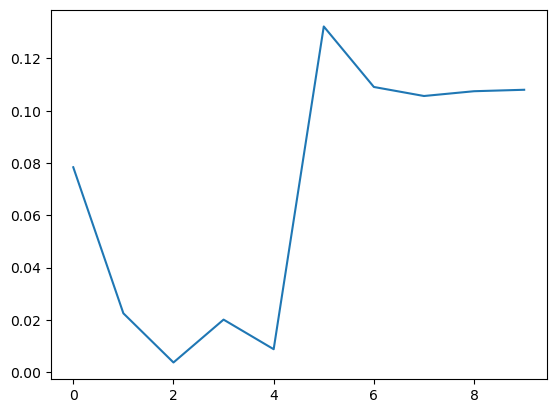

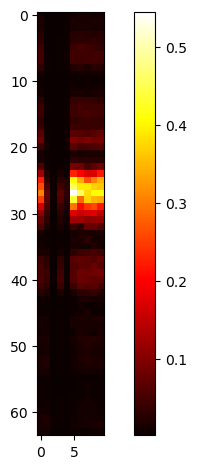

In [19]:
# Visualize the received signal power
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import os
import re

def get_file_num(filename):
		return int(re.findall(r'\d+', filename)[0])

scenario_num = 17
pred_length = 0

# Get the appropriate directory to pull data from
data_dir = "C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Prototyping\\scenario{}\\unit1\\mmWave_data".format(scenario_num)
files = os.listdir(data_dir)

# Load the mmwave samples
full_data = []
for file in sorted(files, key=get_file_num):
	data = np.loadtxt(data_dir + '\\' + file)
	full_data.append(data)
full_data = np.row_stack(full_data)
print(full_data.shape)

observation_size = full_data.shape[1]
full_len = full_data.shape[0]

# fig = plt.figure(figsize=(18,2))
# ax = fig.axes
# # ax.imshow(random.rand(8, 90), interpolation='nearest')

# For scenario 11, 0.5 is a good threshold
# Get the max of each column; columns  where the max is < 0.3 are considered blockage times
# blockages = np.max(full_data, axis=0) < 0.3
# print(np.nonzero(blockages))

# Alternate way of finding blockage points which gives the same results
# blockages = [np.sqrt(np.mean(full_data[:,i]**2)) for i in range(300)]
blockages = [np.sqrt(np.mean(full_data[i,:]**2)) for i in range(89,99)]
# print(blockages)
plt.plot(blockages)
plt.show()

plt.imshow(full_data[89:99,:].T, cmap=cmap.hot, interpolation='nearest')
plt.tight_layout()
plt.colorbar()
plt.show()